In [1]:
import os
import sys
import pickle
import random
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import minmax_scale, scale, StandardScaler
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen


sys.path.append(f"{os.getcwd()}/../")

from src.data.processing.utils import CleanUp, SNOWBALL_STEMMER
from src.database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline

steps = 5

def test_4_stationary(X):
    result = adfuller(X, autolag='AIC')
    pvalue = result[1]
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % pvalue)
    print('Critical Values:')
    for key, value in result[4].items():
        print(' - %s: %.3f' % (key, value))
    print(f"Is the time series stationary? {pvalue < 0.05}")

def test_4_cointegration(y1, y2, trend="c", maxlag=15):
    result = coint(y1, y2, trend=trend, maxlag=maxlag)
    pvalue = result[1]
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % pvalue)
    print('Critical Values:')
    for key, value in zip([1, 5, 10], result[2]):
        print(f' - {key}%: {round(value, 3)}')
    print(f"Is time series cointegrate? {not pvalue < 0.05}")
    
normalizar = CleanUp(remove_stopwords=True)

In [2]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/rdenadai/covid19statistics/master/data/covid-19/brazil/cases-brazil-cities-time-2020-06-14.csv")

covid_data = df_covid[["date", "newCases", "newDeaths"]].copy()
covid_data["date"] = pd.to_datetime(covid_data["date"], format='%Y-%m-%d')
covid_data = covid_data.groupby([covid_data["date"].dt.date]).sum().reset_index()

# print(df_covid.columns)

In [20]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
hashtags_["date"] = hashtags_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
hashtags_ = hashtags_[hashtags_["date"] > pd.Timestamp(2020, 1, 1)]
users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [21]:
# print(hashtags_.columns)
# print(users_.columns)

## Informações da base de dados

In [22]:
print(f"Qtde. de Comentários            : {len(hashtags_)}")
print(f"Qtde. de Comentários positivos  : {len(hashtags_[hashtags_['classify'] == 'positivo'])}")
print(f"Qtde. de Comentários negativos  : {len(hashtags_[hashtags_['classify'] == 'negativo'])}")
print("-" * 40)
print(f"Qtde. de Usuários geolocalizados: {len(users_)}")
print(f"Qtde. de Usuários em SP         : {len(users_[users_['state'] == 'SP'])}")
print(f"Qtde. de Usuários em RJ         : {len(users_[users_['state'] == 'RJ'])}")

Qtde. de Comentários            : 250385
Qtde. de Comentários positivos  : 94704
Qtde. de Comentários negativos  : 108275
----------------------------------------
Qtde. de Usuários geolocalizados: 62336
Qtde. de Usuários em SP         : 12304
Qtde. de Usuários em RJ         : 12914


Exemplos de comentários com suas classificações:

In [23]:
for idx, row in hashtags_.sample(n=5).iterrows():
    print(f"{row.classify}|{row.comment}")

positivo|Em resposta a  @jrcorreaa Amiga, agora eu resolvo tudo  c estou com Covid.
positivo|Só queria conseguir dormir em paz, mas essa dor de garganta fodida não me deixa
negativo|Em resposta a  @_leosv Eu estou assim também Léo, mas ignorar completamente as mortes e as pessoas que estão sofrendo de maneira geral por conta do Corona e sair pra beber com os amigos fere totalmente o que eu sou e no que eu acredito
negativo|o cara virou uma piada mesmo
positivo|Dor de cabeça: a Eu: peguei covid puta merda  Corta pra eu lembrando q não como nada e nem tomo água a 7273726 horas


## Nuvens de palavras

Nuvem de palavras de todos os comentários na base de dados.

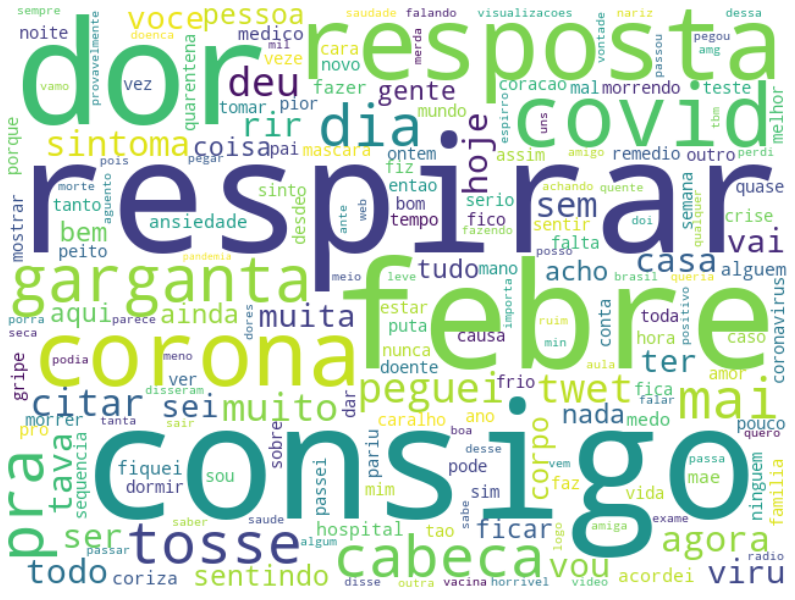

In [7]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Nuvens de palavras apenas de comentários classificados como positivos.

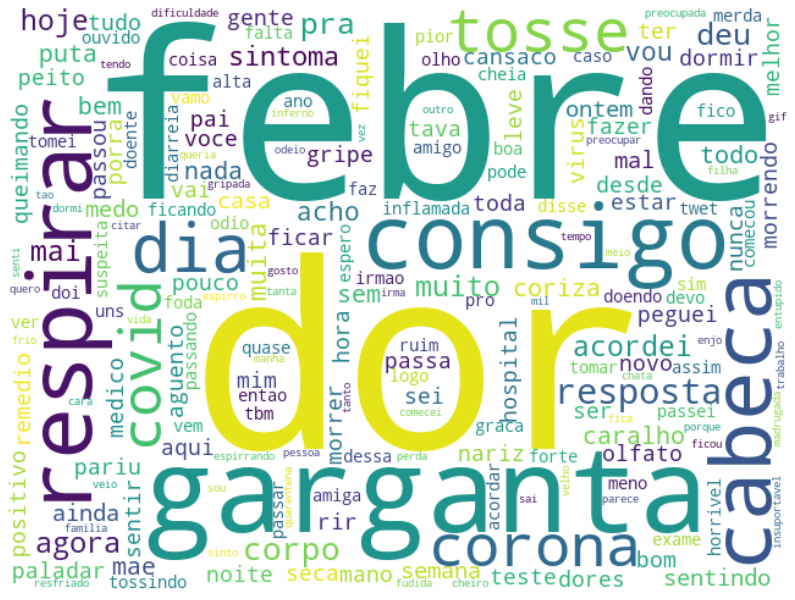

In [8]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_[hashtags_['classify'] == 'positivo']["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Visualizações dos dados

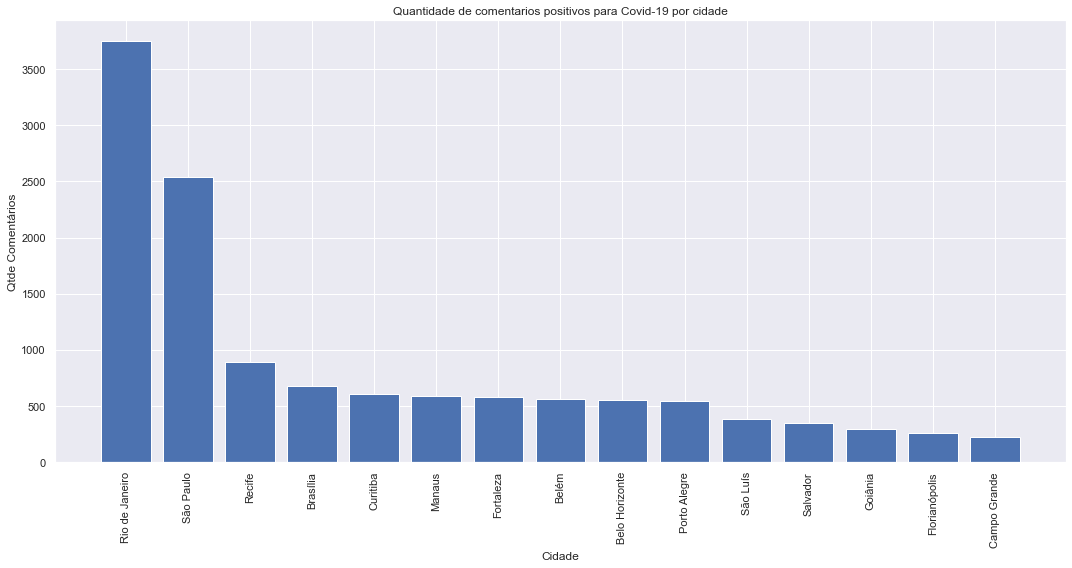

In [24]:
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['city']).sum().reset_index()[['city', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por cidade")
plt.bar(usr['city'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Cidade")
plt.ylabel("Qtde Comentários")
plt.tight_layout()
plt.show()

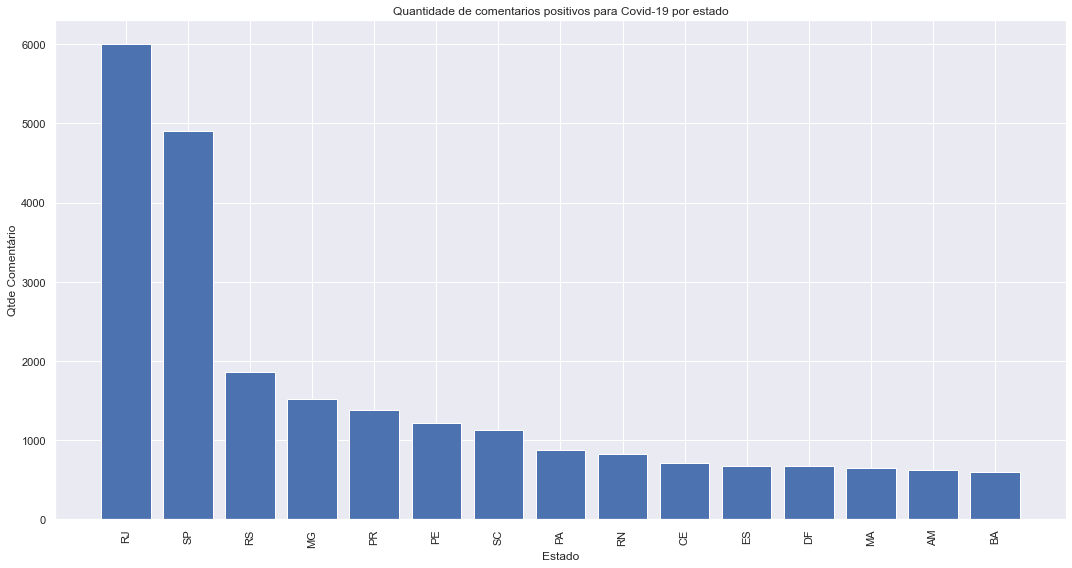

In [25]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['state']).sum().reset_index()[['state', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por estado")
plt.bar(usr['state'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Estado")
plt.ylabel("Qtde Comentário")
plt.tight_layout()
plt.show()

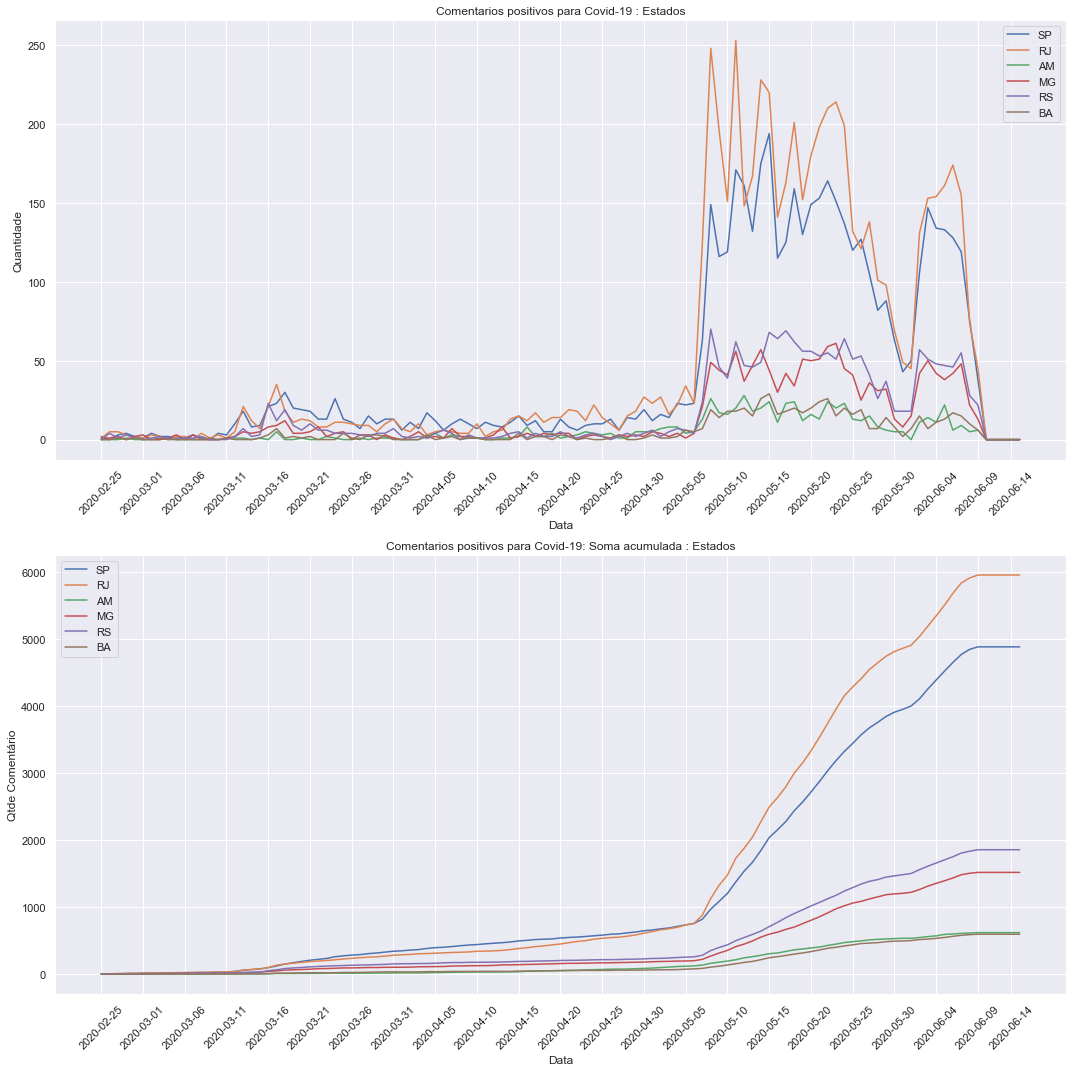

In [26]:
usr = users_.copy()

estados = ["SP", "RJ", "AM", "MG", "RS", "BA"]
list_df = []
for estado in estados:
    usr_ = usr[usr["state"] == estado]
    df_dt_ = hashtags_[
        (hashtags_['username'].isin(usr_['username'])) & (hashtags_['classify'] == 'positivo')
    ].drop_duplicates("username").copy()
    df_dt_['date'] = df_dt_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
    df_dt_['count'] = 1
    df_dt_ = df_dt_.groupby([df_dt_['date'].dt.date]).sum().reset_index()
    df_dt_ = df_dt_[df_dt_['date'] > pd.Timestamp(2020, 1, 1)]
    list_df.append(df_dt_)

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search, list_cnt = row["date"], []
    for df_search in list_df:
        val_ = 0
        found_ = df_search[df_search["date"] == dt_search]
        if len(found_) > 0:
            val_ = int(found_["count"])
        list_cnt.append(val_)
    df_merged.append([dt_search] + list_cnt)
df_merged = pd.DataFrame(df_merged, columns=["date"] + estados)


datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

steps = 5
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.title("Comentarios positivos para Covid-19 : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    plt.plot(tempo, cnt_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comentarios positivos para Covid-19: Soma acumulada : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    cumsum_ = np.cumsum(cnt_)
    plt.plot(tempo, cumsum_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Qtde Comentário")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

datas = df_merged["date"].to_numpy()

tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

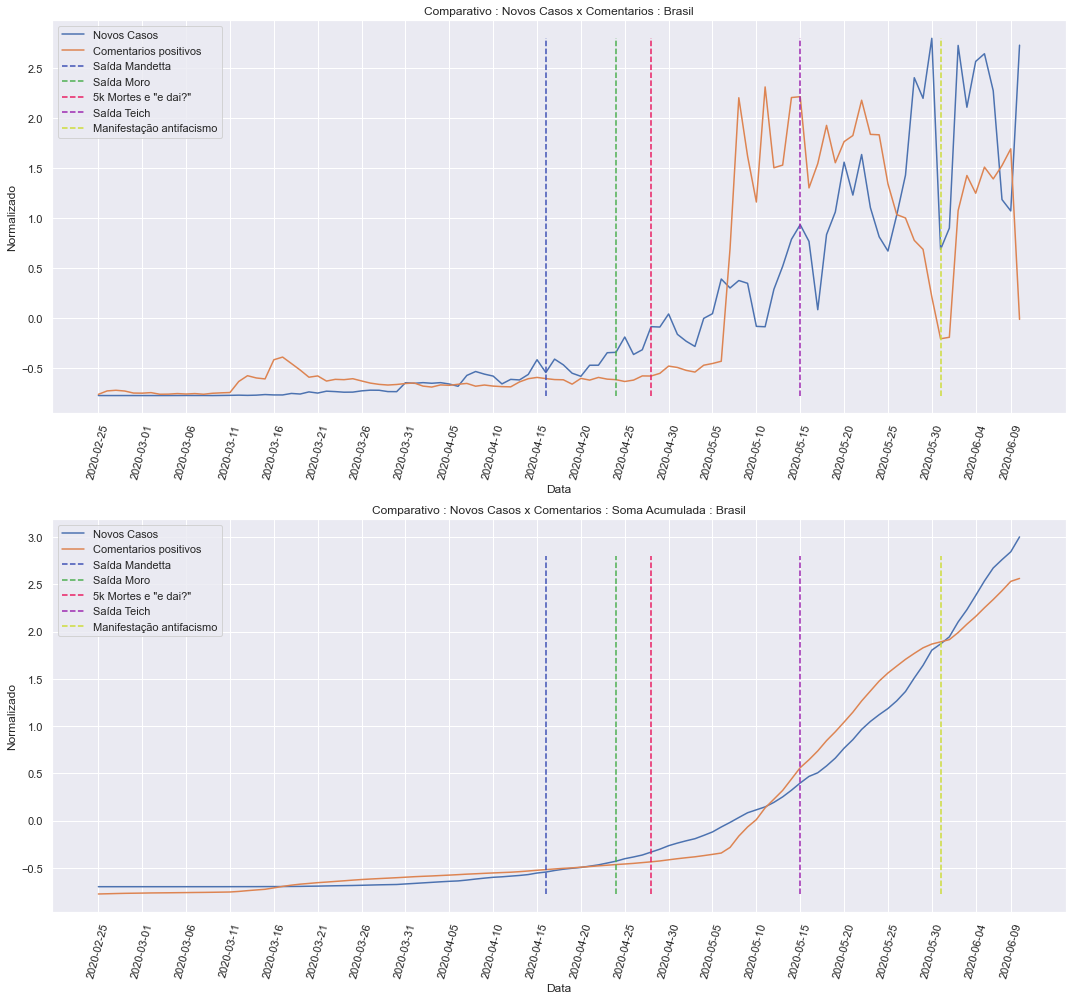

In [28]:
calc_novos_casos = df_merged["newCases"] / 212_000_000
calc_numero_comments = (df_merged["numComments"] * 0.75) / 8_280_000
novos_casos = scale(calc_novos_casos)
numero_comments = scale(calc_numero_comments)
cumsum_novos_casos = scale(np.cumsum(calc_novos_casos))
cumsum_numero_comments = scale(np.cumsum(calc_numero_comments))

idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
mmin, mmax = np.min(novos_casos), np.max(novos_casos)

plt.figure(figsize=(15, 14))
plt.subplot(2, 1, 1)
plt.title("Comparativo : Novos Casos x Comentarios : Brasil")
plt.plot(tempo, novos_casos, label="Novos Casos")
plt.plot(tempo, numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comparativo : Novos Casos x Comentarios : Soma Acumulada : Brasil")
plt.plot(tempo, cumsum_novos_casos, label="Novos Casos")
plt.plot(tempo, cumsum_numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")

plt.ylabel("Normalizado")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
print("Augmented Dickey-Fuller Test:")
print("-" * 30)
print()

print("Novos Casos:")
print("-" * 30)
test_4_stationary(novos_casos)

print()
print("Comentarios positivos:")
print("-" * 30)
test_4_stationary(numero_comments)

print()
print()
print("Engle-Granger Test:")
print("-" * 30)
print()
test_4_cointegration(numero_comments, novos_casos)

Augmented Dickey-Fuller Test:
------------------------------

Novos Casos:
------------------------------
ADF Statistic: 3.915035
p-value: 1.000000
Critical Values:
 - 1%: -3.504
 - 5%: -2.894
 - 10%: -2.584
Is the time series stationary? False

Comentarios positivos:
------------------------------
ADF Statistic: -1.862057
p-value: 0.350116
Critical Values:
 - 1%: -3.496
 - 5%: -2.890
 - 10%: -2.582
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -2.919012
p-value: 0.130733
Critical Values:
 - 1%: -4.004
 - 5%: -3.395
 - 10%: -3.085
Is time series cointegrate? True


In [30]:
df_vecm = pd.DataFrame(np.c_[numero_comments, novos_casos], columns=["Comentarios", "Novos casos"])
model = VECM(df_vecm, k_ar_diff=30)
vecm_res = model.fit()
# print(vecm_res.summary())
# print()
# print()
print(vecm_res.test_granger_causality(caused="Novos casos", causing="Comentarios").summary())
print()
print()
print(vecm_res.test_inst_causality(causing="Comentarios").summary())

Granger causality F-test. H_0: Comentarios does not Granger-cause Novos casos. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         58.17          2.033   0.000 (31, 20)
----------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantaneously cause Novos casos. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         5.800          3.841   0.016  1
----------------------------------------


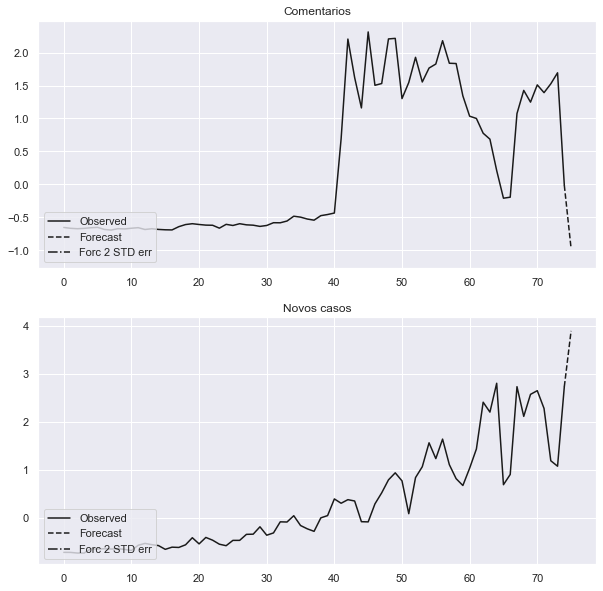

In [31]:
vecm_res.plot_forecast(steps=1)

In [32]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

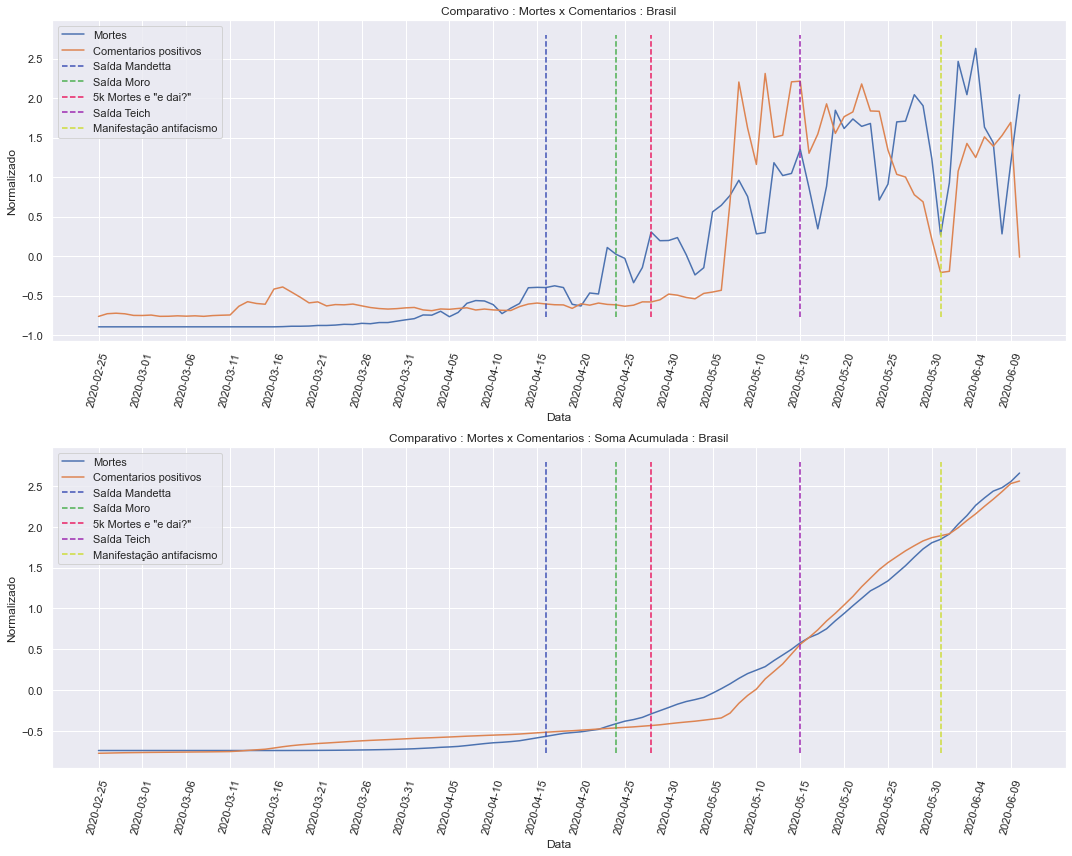

In [33]:
calc_novas_mortes = df_merged["newDeaths"] / 212_000_000
calc_numero_comments = (df_merged["numComments"] * 0.75) / 8_280_000
novas_mortes = scale(calc_novas_mortes)
numero_comments = scale(calc_numero_comments)
cumsum_novas_mortes = scale(np.cumsum(calc_novas_mortes))
cumsum_numero_comments = scale(np.cumsum(calc_numero_comments))

idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
mmin, mmax = np.min(novos_casos), np.max(novos_casos)

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.title("Comparativo : Mortes x Comentarios : Brasil")
plt.plot(tempo, novas_mortes, label="Mortes")
plt.plot(tempo, numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comparativo : Mortes x Comentarios : Soma Acumulada : Brasil")
plt.plot(tempo, cumsum_novas_mortes, label="Mortes")
plt.plot(tempo, cumsum_numero_comments, label="Comentarios positivos")
plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
plt.xticks(numero_tempo, data_tempo, rotation=75)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
print("Augmented Dickey-Fuller Test:")
print("-" * 30)
print()

print("Novas Mortes:")
print("-" * 30)
test_4_stationary(novas_mortes)

print()
print("Comentarios positivos:")
print("-" * 30)
test_4_stationary(numero_comments)

print()
print()
print("Engle-Granger Test:")
print("-" * 30)
print()
test_4_cointegration(numero_comments, novas_mortes)

Augmented Dickey-Fuller Test:
------------------------------

Novas Mortes:
------------------------------
ADF Statistic: 0.970476
p-value: 0.993944
Critical Values:
 - 1%: -3.504
 - 5%: -2.894
 - 10%: -2.584
Is the time series stationary? False

Comentarios positivos:
------------------------------
ADF Statistic: -1.862057
p-value: 0.350116
Critical Values:
 - 1%: -3.496
 - 5%: -2.890
 - 10%: -2.582
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -2.856517
p-value: 0.148363
Critical Values:
 - 1%: -4.004
 - 5%: -3.395
 - 10%: -3.085
Is time series cointegrate? True


In [35]:
df_vecm = pd.DataFrame(np.c_[numero_comments, novas_mortes], columns=["Comentarios", "Mortes"])
model = VECM(df_vecm, k_ar_diff=30)
vecm_res = model.fit()
# print(vecm_res.summary())
# print()
# print()
print(vecm_res.test_granger_causality(caused="Mortes", causing="Comentarios").summary())
print()
print()
print(vecm_res.test_inst_causality(causing="Comentarios").summary())

Granger causality F-test. H_0: Comentarios does not Granger-cause Mortes. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         15.63          2.033   0.000 (31, 20)
----------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantaneously cause Mortes. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         17.73          3.841   0.000  1
----------------------------------------


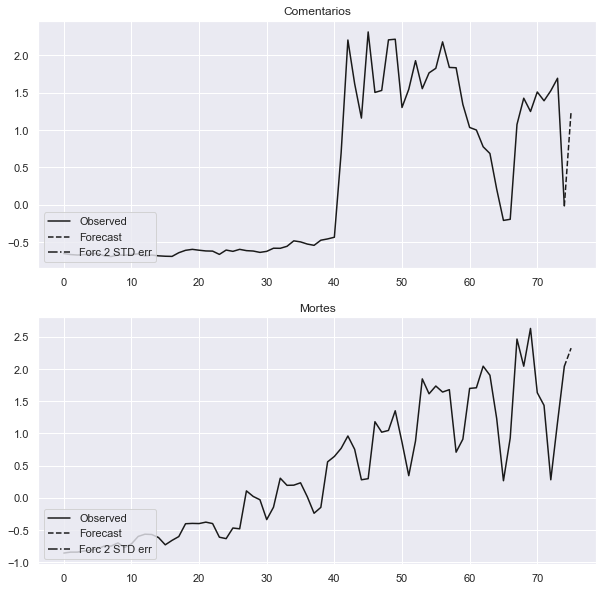

In [36]:
vecm_res.plot_forecast(steps=1)